# Ventilator Waveform Anomaly Detection

## Project Overview
This project focuses on the development of a machine learning-based system to automatically detect and identify anomalies in mechanical ventilator waveforms. The goal is to assist clinicians by providing real-time, data-driven insights into patient-ventilator interaction, thereby improving patient care and clinical outcomes.

## Background & Motivation
Mechanical ventilation is a life-saving intervention in critical care. However, a significant challenge is **patient-ventilator dyssynchrony**, where the patient's respiratory efforts mismatch with the ventilator's delivery.
- **Consequences:** Dyssynchrony can lead to increased work of breathing, diaphragmatic injury, longer ventilation time, and higher mortality.
- **Current Practice:** Relies on clinicians visually inspecting waveform graphs, which is subjective, fatiguing, and may miss subtle but critical events, especially during long-term ventilation.

**Automating this process is crucial for proactive intervention and enhanced clinical decision support.**

## Objectives
1.  **Automate Detection:** To automatically flag sections of ventilator data that contain anomalous patterns indicative of dyssynchrony.
2.  **Classify Anomalies:** To identify and categorize the specific type of dyssynchrony present.
3.  **Provide Insight:** To offer clinicians a clear, interpretable output that pinpoints the timing and nature of the anomaly.

## Data
The project utilizes time-series data streams from mechanical ventilators, typically consisting of four key waveforms:
- **Flow (L/sec):** The rate of air movement into and out of the lungs.
- **Airway Pressure (Paw, cmH₂O):** The pressure in the breathing circuit.
- **Volume (mL):** The amount of air delivered per breath.
- **Muscle Pressure (Pmus, cmH₂O):** The patient's own respiratory muscle effort.

## Target Anomalies (Dyssynchronies)
The system is designed to identify several critical types of dyssynchrony, including but not limited to:
- **Ineffective Triggering:** Patient effort fails to trigger a ventilator breath.
- **Double Triggering:** A single patient effort triggers multiple ventilator breaths.
- **Auto-PEEP (Air Trapping):** Incomplete exhalation leading to elevated baseline pressure.
- **Flow Starvation:** Insufficient ventilator flow rate for patient demand ("Shark Fin" pattern).
- **Reverse Triggering:** ventilator-triggered breath induces a patient's effort.

## Methodology
1.  **Data Preprocessing:**
    - Signal filtering and smoothing to remove noise.
    - Breath segmentation to isolate individual cycles for analysis.
    - Normalization and resampling for consistency.

2.  **Feature Engineering:**
    - Extraction of temporal, spectral, and shape-based features from each breath (e.g., rise time, peak pressure, area under the curve, curvature).
    - Creating features that capture the interaction between different waveforms (e.g., phase angle between Pmus and Paw).

3.  **Modeling Approach:**
    - **Supervised Learning:** Training classifiers (e.g., Random Forest, XGBoost, CNN) on labeled data to categorize breath types.
    - **Unsupervised / Semi-Supervised Learning:** Using algorithms like Isolation Forest or Autoencoders to detect novel or rare anomalies without extensive labels.
    - **Rule-Based Heuristics:** Implementing logic based on clinical definitions (e.g., "if a negative deflection in Paw > threshold during expiration without a subsequent breath, label as ineffective effort").

4.  **Evaluation:**
    - Performance metrics: Precision, Recall, F1-Score, and Confusion Matrix.
    - Clinical validation against annotations from expert intensivists.

## Expected Outcome
A robust software tool or pipeline that can:
- Ingest real-time or historical ventilator waveform data.
- Output a annotated timeline of detected dyssynchrony events.
- Generate reports and visual alerts for clinically significant anomalies.

## Significance
This project bridges the gap between critical care medicine and data science. By leveraging machine learning to interpret complex physiological signals, it aims to create a decision-support system that can reduce clinician cognitive load, standardize ventilation management, and ultimately contribute to better patient outcomes in the ICU.

In [36]:
from signal import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

def inspect_single_file(file_path, patient_id=0):
    print(f"STEP 1: INSPECTING PATIENTS FILES {patient_id}")
    print("_" * 60)

    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Basic information
        print(f" File: {os.path.basename(file_path)}")
        print(f" Shape: {df.shape} (rows: {df.shape[0]}, columns: {df.shape[1]})")
        print(f" Time range: {df['time'].min():.2f} to {df['time'].max():.2f} seconds")

        # Column information
        print(f" Columns: {list(df.columns)}")
        print(f" Data types:")
        print(df.dtypes)

        # Check for missing values
        print(f" Missing values per column:")
        missing_data = df.isnull().sum()
        print(missing_data[missing_data > 0])

        # Basic statistics
        print(f" Basic statistics:")
        print(df.describe())

        # Show first few rows
        print(f" First 5 rows:")
        print(df.head())

        return df

    except Exception as e:
        return None

# Let's test with one file first
patient_files = list(Path("100f").glob("*.csv"))

# Loop through each file
for i, file_path in enumerate(patient_files):
    df = pd.read_csv(file_path)
    inspect_single_file(file_path, patient_id=i)


STEP 1: INSPECTING PATIENTS FILES 0
____________________________________________________________
 File: Run1.csv
 Shape: (15354, 5) (rows: 15354, columns: 5)
 Time range: 0.00 to 153.53 seconds
 Columns: ['time', 'paw', 'flow', 'vol', 'pmus']
 Data types:
time    float64
paw     float64
flow    float64
vol     float64
pmus    float64
dtype: object
 Missing values per column:
Series([], dtype: int64)
 Basic statistics:
               time           paw          flow           vol          pmus
count  15354.000000  15354.000000  15354.000000  15354.000000  15354.000000
mean      76.765000      9.284987     -0.000142      0.084936     -0.831763
std       44.324624      2.490251      0.386601      0.132017      1.374469
min        0.000000      5.849335     -0.805350     -0.024151     -5.473509
25%       38.382500      8.300838     -0.104110     -0.001411     -1.173121
50%       76.765000      8.417437     -0.022147      0.022635     -0.087534
75%      115.147500      8.985041      0.00633

### Merge all patients in single dataFrame (df) AND add pID columns to identify patient

In [37]:
patient_files = list(Path("100f").glob("*.csv"))
all_patients_data = []

# Loop through each file
for i, file_path in enumerate(patient_files):
    df = pd.read_csv(file_path)
    df['pID'] = i
    all_patients_data.append(df)



In [38]:
if all_patients_data:
    merged_df = pd.concat(all_patients_data, ignore_index=True)
    print(f"\nMerged DataFrame shape: {merged_df.shape}")
    print(f"Unique patients: {merged_df['pID'].nunique()}")
    print(f"Columns: {list(merged_df.columns)}")

    # Show first few rows with pID
    print("\nFirst 5 rows of merged data:")
    print(merged_df.head())
    print("\nLast 5 rows of merged data:")
    print(merged_df.tail())



Merged DataFrame shape: (1745928, 6)
Unique patients: 100
Columns: ['time', 'paw', 'flow', 'vol', 'pmus', 'pID']

First 5 rows of merged data:
   time       paw      flow       vol      pmus  pID
0  0.00  8.267437  0.004503  0.000000  0.000000    0
1  0.01  8.235019 -0.025890 -0.000002 -0.000394    0
2  0.02  8.232418  0.005742 -0.000012 -0.001571    0
3  0.03  8.181379  0.005054 -0.000027 -0.003511    0
4  0.04  8.179352  0.004899 -0.000043 -0.006185    0

Last 5 rows of merged data:
           time       paw      flow       vol  pmus  pID
1745923  188.78  7.004472  0.000996 -0.013527   0.0   99
1745924  188.79  7.003815 -0.000047 -0.013528   0.0   99
1745925  188.80  7.021380  0.016381 -0.013528   0.0   99
1745926  188.81  6.986946  0.022413 -0.013529   0.0   99
1745927  188.82  6.795783  0.007876 -0.013530   0.0   99


##### Drop pmus Column from df

In [40]:
# drop pmus column
df=merged_df
df = df.drop('pmus', axis=1)

print(df.head())
print(df.tail())

   time       paw      flow       vol  pID
0  0.00  8.267437  0.004503  0.000000    0
1  0.01  8.235019 -0.025890 -0.000002    0
2  0.02  8.232418  0.005742 -0.000012    0
3  0.03  8.181379  0.005054 -0.000027    0
4  0.04  8.179352  0.004899 -0.000043    0
           time       paw      flow       vol  pID
1745923  188.78  7.004472  0.000996 -0.013527   99
1745924  188.79  7.003815 -0.000047 -0.013528   99
1745925  188.80  7.021380  0.016381 -0.013528   99
1745926  188.81  6.986946  0.022413 -0.013529   99
1745927  188.82  6.795783  0.007876 -0.013530   99


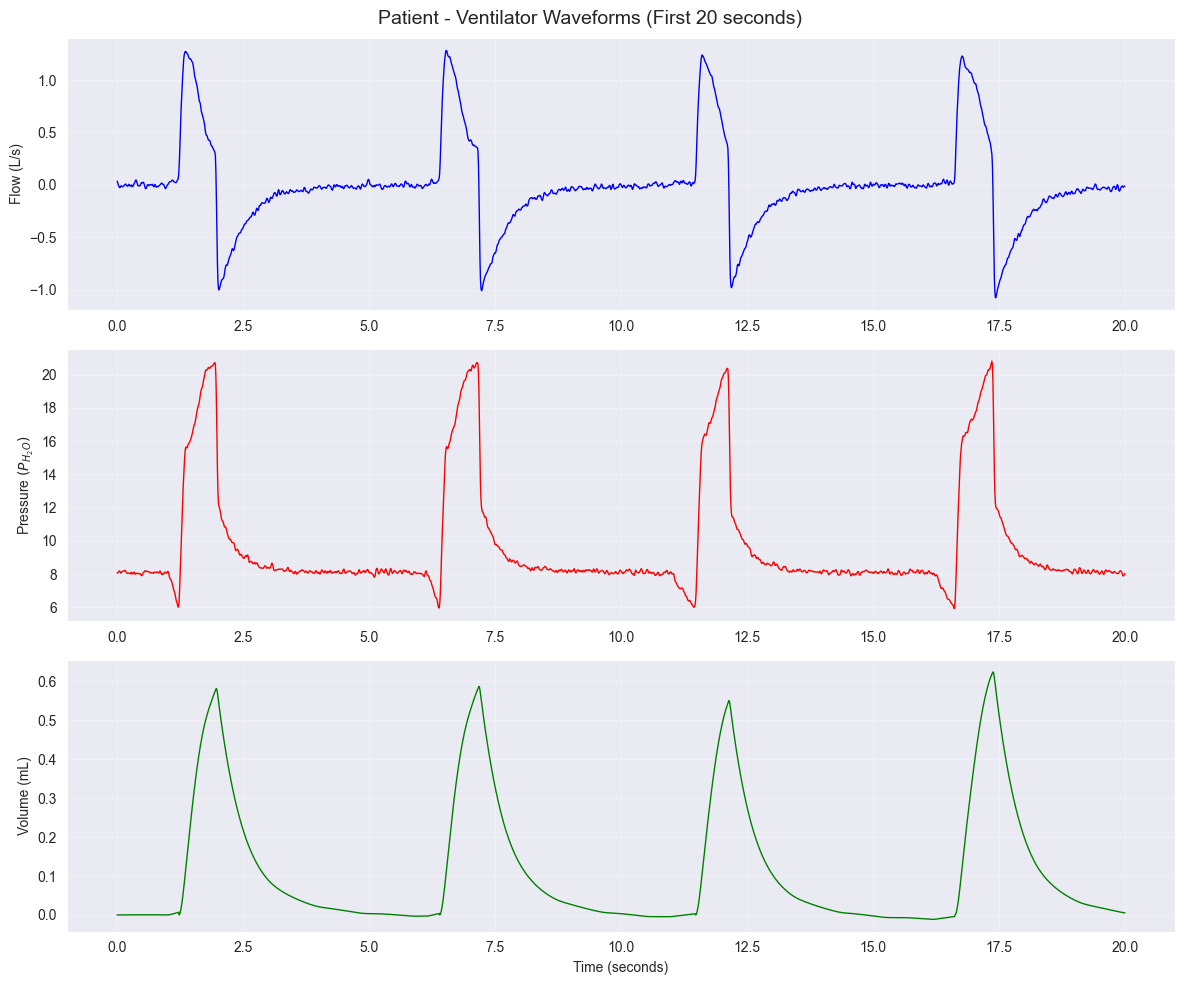

In [41]:

first_patient_df = df[df['pID']==5]

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle(f'Patient - Ventilator Waveforms (First 20 seconds)', fontsize=14)

# Plot each waveform
waveforms = ['flow', 'paw', 'vol']
colors = ['blue', 'red', 'green']
ylabels = ['Flow (L/s)', 'Pressure $(P_{H_2O})$', 'Volume (mL)']

for i, (waveform, color, ylabel) in enumerate(zip(waveforms, colors, ylabels)):
    if waveform in first_patient_df.columns:
        # Show only first 20 seconds for clarity
        subset = first_patient_df[first_patient_df['time'] <= 20] if 'time' in first_patient_df.columns else first_patient_df.head(1000)
        axes[i].plot(subset['time'] if 'time' in first_patient_df.columns else subset.index,
                    subset[waveform], color=color, linewidth=1)
        axes[i].set_ylabel(ylabel)
        axes[i].grid(True, alpha=0.3)


axes[-1].set_xlabel('Time (seconds)')
plt.tight_layout()
plt.show()